## Analysis notebook for atmosphere NetCDF files

### Define utils

In [68]:
import numpy as np
import netCDF4 as nc
from copy import deepcopy
import glob
import os
from scipy.interpolate import PchipInterpolator

import matplotlib as mpl
font = {'family' : 'sans',
        'size'   : 12}

mpl.rc('font', **font)
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import MultipleLocator, LogLocator, MaxNLocator
import matplotlib.pyplot as plt

import pandas as pd
from cmcrameri import cm


In [69]:
from proteus.config import read_config
from proteus.utils.plot import observer_bands
import utils.load_grid as lg

In [70]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

# %matplotlib widget

In [71]:
def readrun(f, stride=1):
    print("Reading files in '%s'..." % f)
    ncdfs = glob.glob(f+"/data/*_atm.nc")
    if len(ncdfs) == 0:
        raise Exception("No files found!")

    years = [float(s.split("/")[-1].split("_")[0]) for s in ncdfs]

    if stride < 0:
        mask = [np.argsort(years)[-1]]
    else:
        mask = np.argsort(years)[::int(stride)]

    ncdfs = np.array([ncdfs[i] for i in mask])
    years = np.array([years[i] for i in mask])
    data  = np.array([lg.readncdf(f) for f in ncdfs])

    print("    Done reading %d files" % len(years))
    print("    Final time = %1.3e years" % years[-1])
    return years, data

def read_helpfile(fpath):
    return pd.read_csv(fpath, sep=r'\s+')

cff_max = None

### Do analysis

In [72]:
pltname = "hd63433d"
outname = "article_data/mnras_proteus_agni/hd63433d_oxfu/"
title = "HD 63433 d"

# cff_max = {
#             -5.0 : 1.41e-03,
#             -4.0 : 2.66e-03,
#             -3.0 : 2.72e-03,
#             -2.0 : 6.63e-03,
#             -1.0 : 1.61e-02,
#              0.0 : 1.61e-02,
#              1.0 : 1.22e-02,
#              2.0 : 9.30e-03,
#              3.0 : 8.02e-02,
#              4.0 : 6.06e-02,
#              5.0 : 5.57e-03,
# }

pltname = "trappist1c"
outname = "article_data/mnras_proteus_agni/trappist1c_oxfu/"
title = "TRAPPIST-1 c"
cff_max = {
            -5.0 : 8.88e-03,
            -4.0 : 6.65e-03,
            -3.0 : 5.06e-03,
            -2.0 : 4.00e-03,
            -1.0 : 3.30e-03,
            0.0  : 3.79e-03,
            1.0  : 8.01e-03,
            2.0  : 3.12e-02,
            3.0  : 2.37e-02,
            4.0  : 2.41e-02,
            5.0  : 2.46e-02,
}

stride = -1

In [73]:
globber = os.path.join(os.environ.get("HOME"),"analysis/data/",outname) + "/case_*/"
print(globber)
cases = glob.glob(globber)

npoints = len(cases)
print("npoints = %d"%npoints)
if npoints < 1:
    raise

data = []
help = []
conf = []
post = []
for folder in cases:
    y,d = readrun(folder, stride=stride)
    data.append( (y,d) )
    conf.append( read_config(folder+"init_coupler.toml") )
    help.append( read_helpfile(folder+"runtime_helpfile.csv") )
print("Done")

/home/n/nichollsh/analysis/data/article_data/mnras_proteus_agni/trappist1c_oxfu//case_*/
npoints = 22
Reading files in '/home/n/nichollsh/analysis/data/article_data/mnras_proteus_agni/trappist1c_oxfu/case_00000/'...
    Done reading 1 files
    Final time = 1.057e+06 years
Reading files in '/home/n/nichollsh/analysis/data/article_data/mnras_proteus_agni/trappist1c_oxfu/case_00001/'...
    Done reading 1 files
    Final time = 9.539e+05 years
Reading files in '/home/n/nichollsh/analysis/data/article_data/mnras_proteus_agni/trappist1c_oxfu/case_00002/'...
    Done reading 1 files
    Final time = 1.215e+06 years
Reading files in '/home/n/nichollsh/analysis/data/article_data/mnras_proteus_agni/trappist1c_oxfu/case_00003/'...
    Done reading 1 files
    Final time = 1.548e+06 years
Reading files in '/home/n/nichollsh/analysis/data/article_data/mnras_proteus_agni/trappist1c_oxfu/case_00004/'...
    Done reading 1 files
    Final time = 2.519e+06 years
Reading files in '/home/n/nichollsh/an

## Plot flux and meltfrac vs time

In [74]:
indep_var = "outgas.fO2_shift_IW"
indep_lbl = r"log$_{10}$ (fO$_{2}$ / IW)"

indep_vals = set()
for i in range(npoints):
    indep_vals.add(lg.descend_get(conf[i],indep_var))

indep_max = np.amax(np.abs(list(indep_vals)))
indep_unique = np.unique(list(indep_vals))


In [75]:
print(indep_unique)

[-5. -4. -3. -2. -1.  0.  1.  2.  3.  4.  5.]


In [76]:
cmap = cm.batlow_r
norm = mpl.colors.Normalize(vmin=-indep_max, vmax=indep_max)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)

In [77]:
plt.close("all")

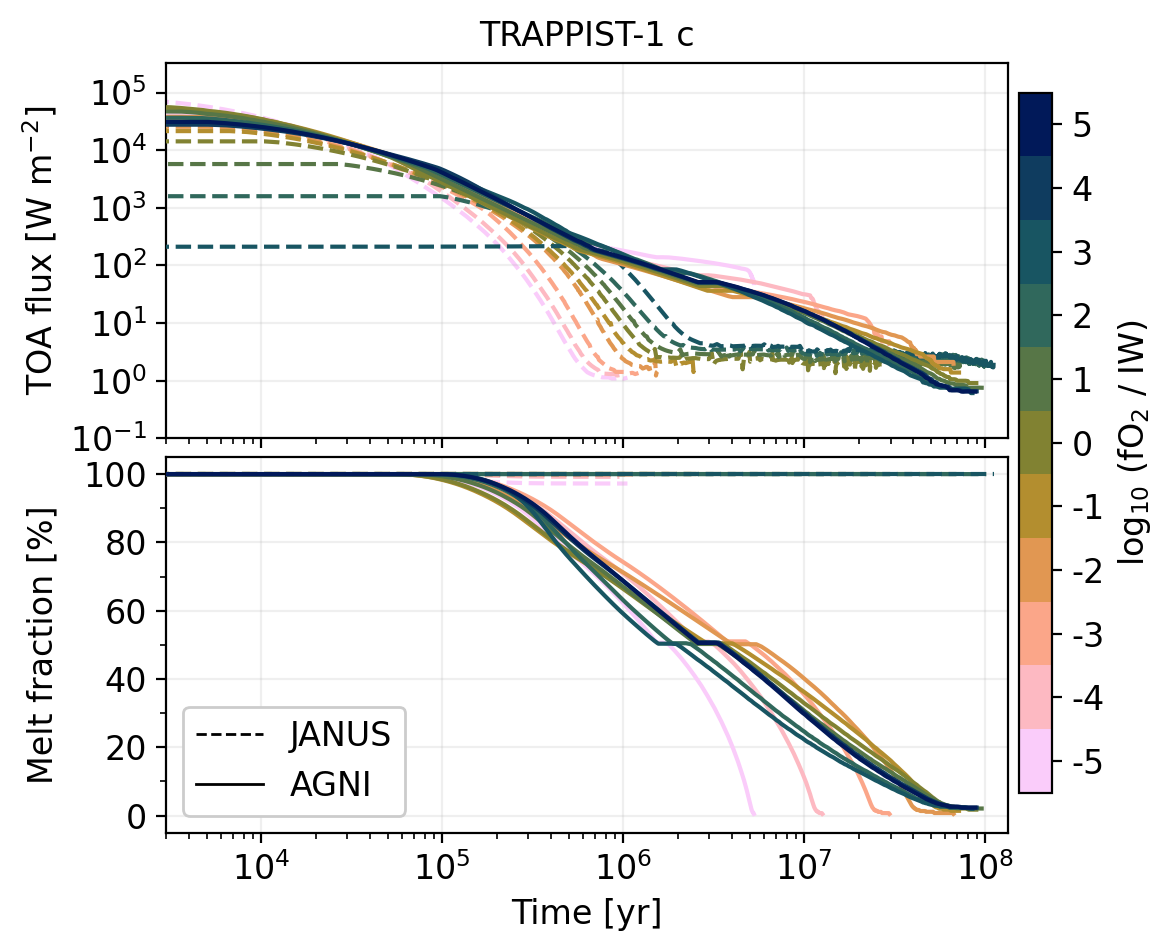

AGNI max time: 9.5659e+07 yr
  at  outgas.fO2_shift_IW[17]: 1.0


In [78]:
fig,(ax1,ax2) = plt.subplots(2,1, sharex=True, figsize=(5.5,5))

crop = None

agni_maxt = 0
agni_maxi = -1

xmin = 3e3
xmax = xmin+1
for i in range(npoints):
    col = sm.to_rgba(float(lg.descend_get(conf[i],indep_var)))

    x = help[i]["Time"][0:crop]
    xmax = max(xmax, np.amax(x))

    ls = 'solid'
    lbl = 'AGNI'
    if lg.descend_get(conf[i],"atmos_clim.module") == "janus":
        ls='dashed'
        lbl = "JANUS"
    else:
        this_max_x = np.amax(x)
        if this_max_x > agni_maxt:
            agni_maxt = this_max_x
            agni_maxi = i

    y1 = np.array(help[i]["F_atm"][0:crop])
    ax1.plot(x,y1,linestyle=ls, c=col, zorder=i)

    y2 = np.array(help[i]["Phi_global"][0:crop]) * 1e2
    ax2.plot(x,y2,linestyle=ls, c=col, zorder=i, label=lbl)


lg.add_cbar(fig, sm, ticks=indep_unique, label=indep_lbl)
lg.make_legend(ax2)

ax1.set_title(title, fontsize=12)
ax1.set_xscale("log")
ax1.set_xlim(left=xmin, right=xmax*1.2)
ax1.grid(zorder=-2, alpha=0.2)
ax2.grid(zorder=-2, alpha=0.2)
ax2.set_xlabel("Time [yr]")

ax1.set_yscale("log")
ax1.set_ylabel(r"TOA flux [W m$^{-2}$]")
ax1.set_ylim(bottom=0.1)
ax1.yaxis.set_major_locator(LogLocator(numticks=100))

ax2.set_ylim(top=105, bottom=-5)
ax2.set_ylabel('Melt fraction [%]')
ax2.yaxis.set_major_locator(MultipleLocator(20))
ax2.yaxis.set_minor_locator(MultipleLocator(10))

fig.align_ylabels()
fig.subplots_adjust(hspace=0.05)
plt.show()

for fmt in ["png","pdf"]:
    fig.savefig("output/agni_v_janus/%s/evolve.%s"%(pltname,fmt),bbox_inches='tight', dpi=300)

print("AGNI max time: %.4e yr"%agni_maxt)
print("  at  %s[%d]: %s"%(indep_var, agni_maxi, lg.descend_get(conf[agni_maxi],indep_var)))

## Plot scalar quantities

In [79]:
def plot_scalar_quantities(yd, props, yd_right=None):
    fig,ax = plt.subplots(1,1, sharex=True, figsize=(6,1.5))

    if yd_right is not None:
        axr = ax.twinx()

    ms = 60

    x_vals = []
    y_vals = []

    yr_vals = []
    xr_vals = []

    for i in range(npoints):
        x = float(lg.descend_get(conf[i],indep_var))
        dat = data[i][1][0]
        y = help[i][yd["key"]].iloc[-1] * yd["scl"]

        col = sm.to_rgba(x)
        marker = 's'
        lbl = "AGNI"
        if lg.descend_get(conf[i],"atmos_clim.module") == "janus":
            marker = 'o'
            lbl = "JANUS"

        ax.scatter(x,y, marker=marker, color=col, edgecolors="k", s=ms, label=lbl, zorder=2)

        x_vals.append(x)
        y_vals.append(y)

        if (yd_right is not None) and (lbl == "AGNI"):
            xr_vals.append(x)
            yr_vals.append( help[i][yd_right["key"]].iloc[-1] * yd_right["scl"])

    if yd_right is not None:
        axr.plot(xr_vals, yr_vals, c=yd_right['col'])
        axr.set_ylabel(yd_right["lbl"])
        axr.set_xticks([])
        axr.yaxis.label.set_color(yd_right['col'])
        axr.tick_params(axis='y', colors=yd_right['col'])
        if len(yd_right["loc"]) == 2:
            axr.set_ylim(yd_right["loc"][0], yd_right["loc"][1])
        elif len(yd_right["loc"]) > 0:
            axr.set_yticks(yd_right["loc"])

    if props["xlabel"]:
        ax.set_xlabel(indep_lbl)
    ax.set_ylabel(yd["lbl"])
    ax.set_xticks(np.unique(x_vals))

    if len(yd["loc"]) == 2:
        ax.set_ylim(yd["loc"][0], yd["loc"][1])
    elif len(yd["loc"]) > 0:
        ax.set_yticks(yd["loc"])
        if yd["key"] == "Phi_global":
            ax.set_ylim(-5, 105)
    ax.set_title(title, fontsize=12)

    print(yd["lbl"]+":", y_vals)

    if props["legend"]:
        lg.make_legend(ax, loc='center right', alpha=1)
    ax.grid(zorder=-2, alpha=0.2)

    plt.show()

    for fmt in ["png","pdf"]:
        name = yd["key"]
        if yd_right is not None:
            name += "_%s"%yd_right["key"]
        fig.savefig("output/agni_v_janus/%s/%s.%s"%(pltname,name,fmt),bbox_inches='tight', dpi=300)


Melt fraction [%]: [97.24163999999999, 99.21337, 99.90054, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 0.4785142, 0.47886270000000003, 0.46889080000000005, 0.4994431, 1.391585, 1.736998, 2.066383, 2.2011119999999997, 1.9756639999999999, 2.330488, 2.329532]


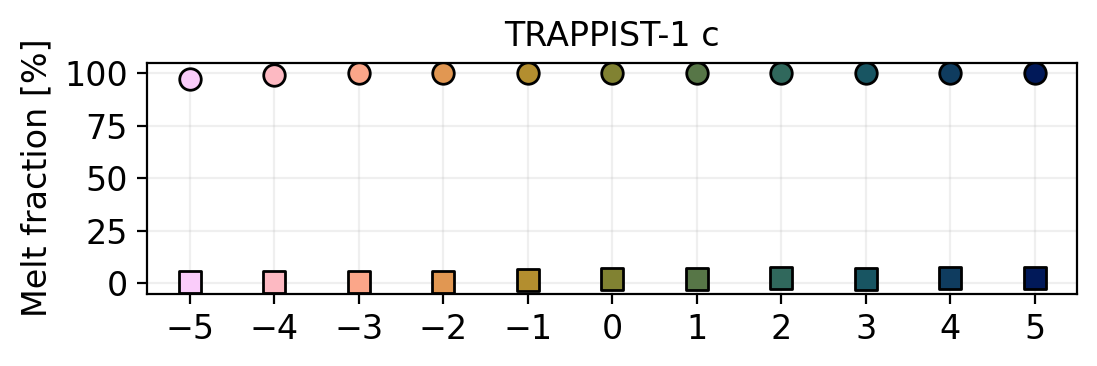

Melt fraction [%]: [97.24163999999999, 99.21337, 99.90054, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 0.4785142, 0.47886270000000003, 0.46889080000000005, 0.4994431, 1.391585, 1.736998, 2.066383, 2.2011119999999997, 1.9756639999999999, 2.330488, 2.329532]


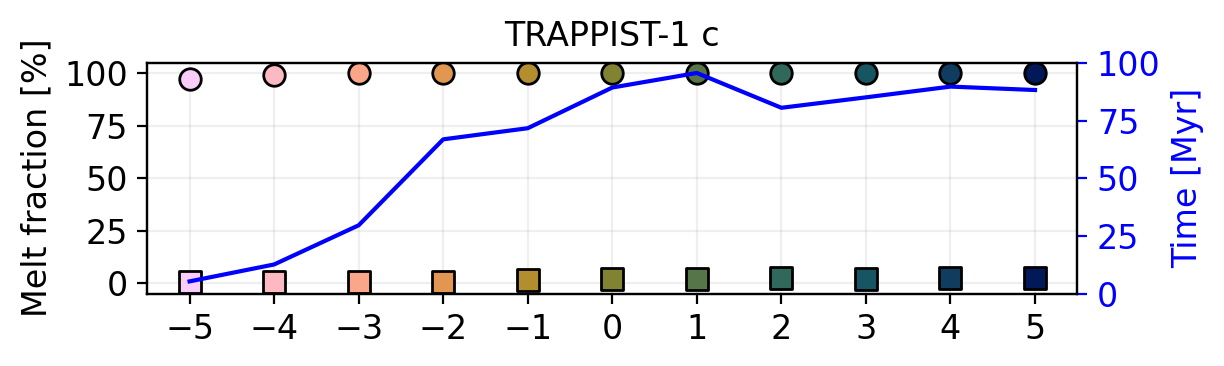

Time [Myr]: [1.0565309999999999, 0.953878, 1.215428, 1.547869, 2.519154, 26.206789999999998, 72.42134, 101.4554, 111.3485, 2e-06, 2e-06, 5.279246, 12.615789999999999, 29.600179999999998, 66.88058, 71.70804, 89.34946, 95.65896, 80.56093, 85.08793, 89.75441, 88.26557]


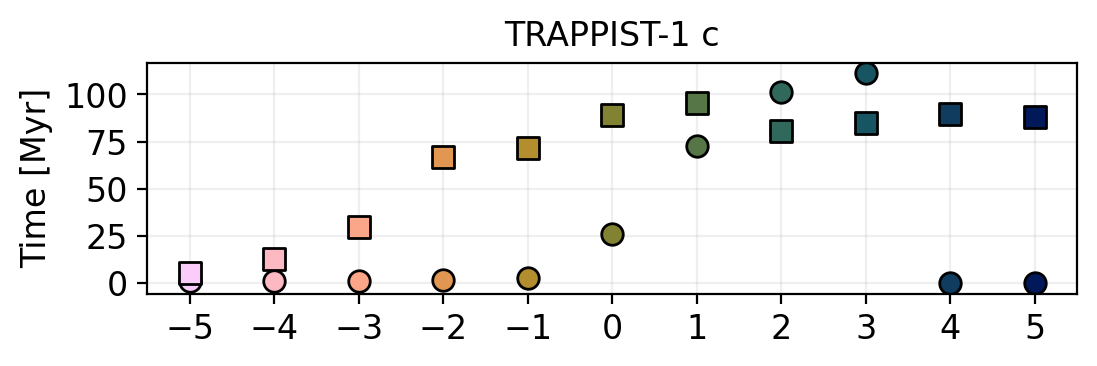

Melt fraction [%]: [97.24163999999999, 99.21337, 99.90054, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 0.4785142, 0.47886270000000003, 0.46889080000000005, 0.4994431, 1.391585, 1.736998, 2.066383, 2.2011119999999997, 1.9756639999999999, 2.330488, 2.329532]


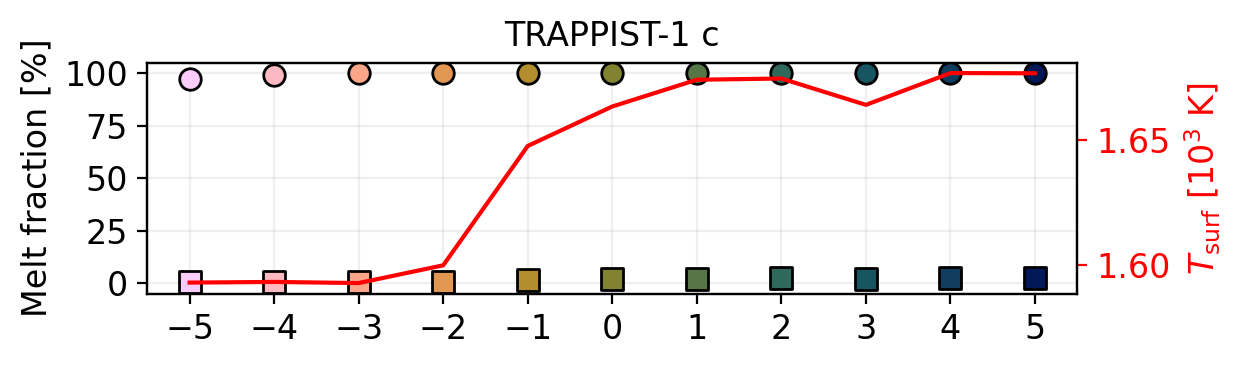

Albedo [%]: [0.1639628, 0.3700246, 0.6667541, 0.9428000000000001, 1.106699, 1.199346, 1.289574, 1.4132209999999998, 1.5668540000000002, 1.699186, 1.902148, 1.821173, 1.52069, 1.292912, 1.1431550000000001, 1.047182, 1.01845, 1.026706, 1.040789, 1.0436809999999999, 1.0440150000000001, 1.042386]


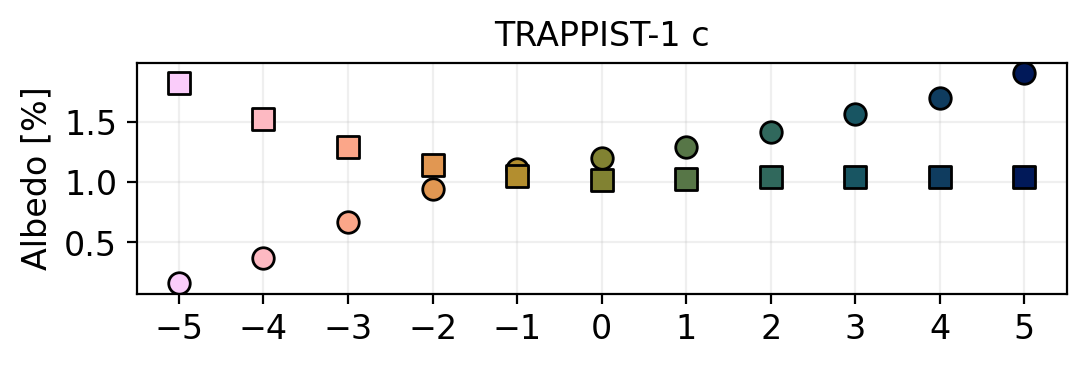

In [80]:
props = {
    "xlabel": False,
    "legend": False,
}

yd_phi = {
    "lbl" : "Melt fraction [%]",
    "key" : "Phi_global",
    "scl" : 100.0,
    "loc" : [0, 25, 50, 75, 100],
}

yd_tim = {
    "lbl" : "Time [Myr]",
    "key" : "Time",
    "scl" : 1e-6,
    "loc" : [0, 25, 50, 75, 100],
    "col" : "blue",
}

yd_tsu = {
    "lbl" : r"$T_{\text{surf}}$ [$10^3$ K]",
    "key" : "T_surf",
    "scl" : 1e-3,
    "loc" : [],
    "col" : "red"
}


plot_scalar_quantities(yd_phi, props)
plot_scalar_quantities(yd_phi, props, yd_right=yd_tim)
plot_scalar_quantities(yd_tim, props)
plot_scalar_quantities(yd_phi, props, yd_right=yd_tsu)


yd = {
    "lbl" : "Albedo [%]",
    "key" : "bond_albedo",
    "scl" : 100.0,
    "loc" : [],
}
plot_scalar_quantities(yd, props)

## Plot T(p) at endpoint

0.00888
0.00665
0.00506
0.004
0.0033
0.00379
0.00801
0.0312
0.0237
0.0241
0.0246


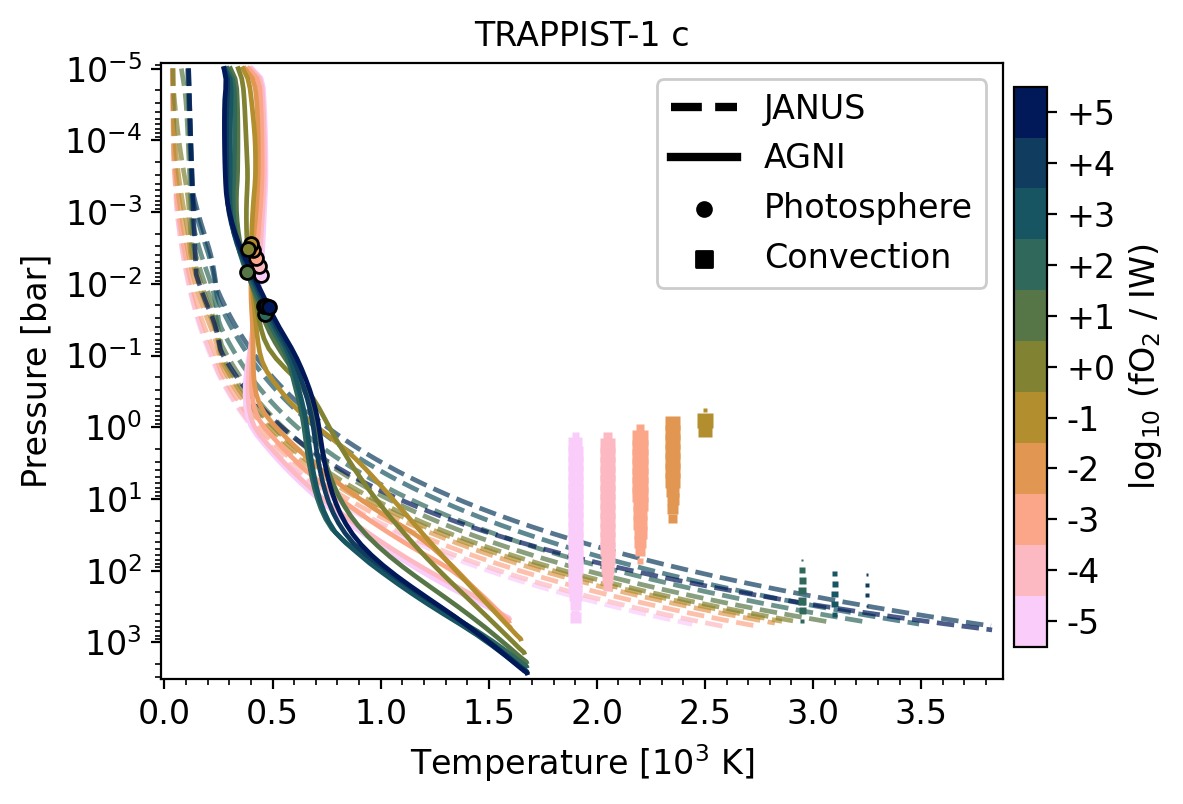

In [87]:
fig,ax = plt.subplots(1,1, figsize=(5.5,4))

janus_alpha = 0.7

ymin = 1; ymax = 10
xmin = 1.0; xmax = 1.5
lw = 1.7
idx = -1
agni_i = -1

smax = 30

for i in range(npoints):
    yrs = data[i][0]
    dat = data[i][1]
    ind = lg.descend_get(conf[i],indep_var)

    col = sm.to_rgba(ind)
    ls = 'solid'
    lbl = 'AGNI'
    al = 1.0
    if lg.descend_get(conf[i],"atmos_clim.module") == "janus":
        lbl = "JANUS"
        ls='dashed'
        mask = []
        al = janus_alpha
        zorder = i
    else:
        agni_i += 1
        convect = np.abs(dat[idx]["fl_cnvct"] / dat[idx]["fl_tot"])
        mask = np.argwhere(convect > 1.0e-9)
        zorder= i+50

    # plot temperature profile
    x = dat[idx]["tmpl"] / 1e3
    y = dat[idx]["pl"] * 1e-5
    ax.plot(x,y,label=lbl, linestyle=ls, c=col, zorder=zorder, lw=lw, alpha=al)

    ymax = max(ymax, np.amax(y))
    ymin = min(ymin, np.amin(y))
    xmax = max(xmax, np.amax(x))
    xmin = min(xmin, np.amin(x))

    # plot convection as scatter points
    if len(mask) >= 2:
        y_c = y[mask]
        x_c = np.ones(np.shape(y_c))*0.15*agni_i+1.9
        sarr = np.clip(convect[mask], 0, 1) * smax
        ax.scatter(x_c,y_c, color=col, zorder=zorder, s=sarr, marker='s', edgecolors=(0,0,0,0))

    # plot cff peak
    if (cff_max is not None) and (lbl == 'AGNI'):
        cff_p = cff_max[ind]
        cff_i = np.argmin(np.abs(y-cff_p)) # get index of peak
        print(cff_p)
        ax.scatter(x[cff_i],y[cff_i], marker='.', color=col, zorder=zorder+100, s=100, label="Photosphere", edgecolors='k')

# add scatter points to legend
ax.scatter(-1,-1,s=smax, c='k', marker='s', label="Convection")

lg.add_cbar(fig, sm, ticks=indep_unique, label=indep_lbl, tick_format="%+d")
ax.set_title(title, fontsize=12)

leg = lg.make_legend(ax, lw=3.0)
ax.set_xlabel(r"Temperature [$10^3$ K]")

ax.xaxis.set_major_locator(MultipleLocator(0.5))
ax.xaxis.set_minor_locator(MultipleLocator(0.1))
ax.set_xlim(left=xmin-0.05, right=xmax+0.05)

ax.set_ylim(top=ymin/1.2, bottom=ymax*1.2)
ax.set_yscale("log")
ax.set_ylabel('Pressure [bar]')

plt.show()

for fmt in ["png","pdf"]:
    fig.savefig("output/agni_v_janus/%s/profiles.%s"%(pltname,fmt),bbox_inches='tight', dpi=300)

## Plot field over time

In [82]:
field = "fl_cnvct"

In [83]:
# work out which indicies we want
idxs_plot = []
for i in range(npoints):
    if lg.descend_get(conf[i],"atmos_clim.module") == "agni":
        idxs_plot.append(i)
indep_vals = [lg.descend_get(conf[i],indep_var) for i in idxs_plot]
mask = np.argsort(indep_vals)
idxs_plot = [idxs_plot[i] for i in mask]
print("Cases:",idxs_plot)

Cases: [11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]


In [84]:
z_all = []
for i in idxs_plot:
    dat = data[i][1]
    for j in range(len(dat)):
        val = np.abs(dat[j][field])
    z_all.extend(list(val))

zmax = np.percentile(z_all, 99.9)
print(zmax)

58.723403647970635


In [85]:
conv_cmap = deepcopy(cm.devon_r)
conv_cmap.set_under((1,1,1,0))

conv_norm = mpl.colors.Normalize(vmin=0, vmax=zmax)
conv_sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)

Exception: Cannot make contour plot from only one time sample

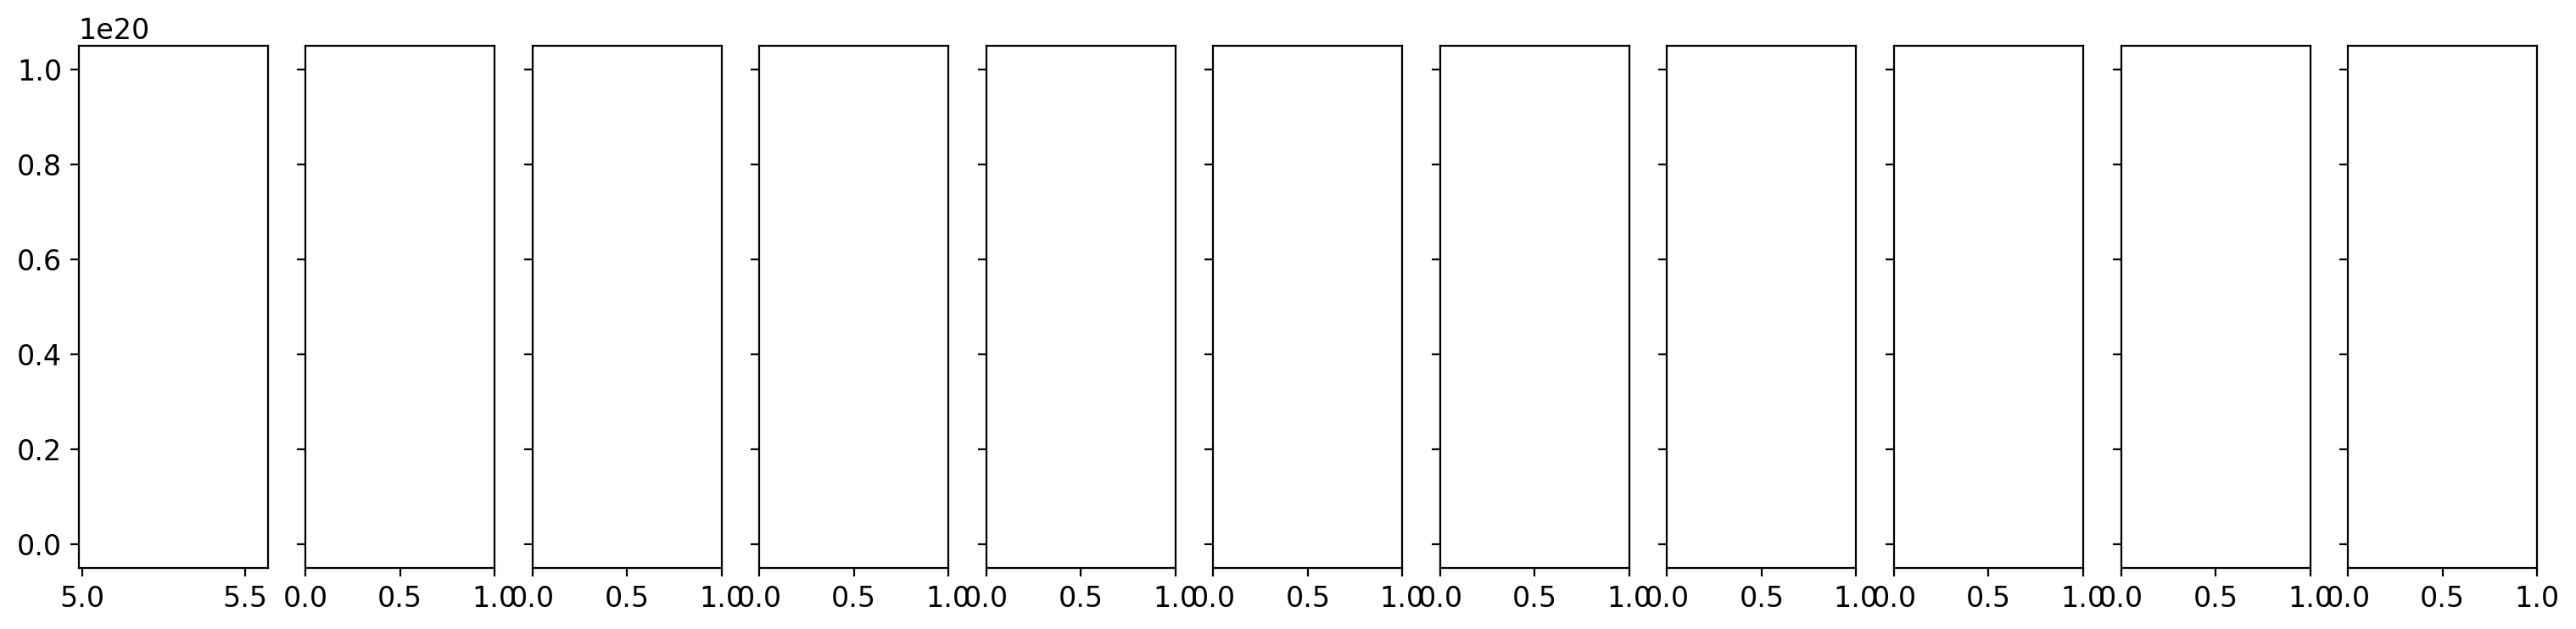

In [86]:
nax = int(npoints/2)
fig,axs = plt.subplots(1,nax,figsize=(1.7*nax,4), sharey=True)

ymin = 1e-4
ymax = 1e1

itp_points = 110
interpolate = False
logx = False

c = 'tab:red'

iax = -1
for i in idxs_plot:
    iax += 1

    yrs = data[i][0]
    dat = data[i][1]

    psurf = []
    times = []

    pts_xs = []
    pts_ys = []
    pts_zs = []
    for j in range(0,len(yrs)):

        if yrs[j] < 10:
            continue

        # time
        t = yrs[j]/1e6
        times.append(t)

        # pressure array
        y = dat[j]["pl"]*1e-5
        psurf.append(np.amax(y))
        ymax = max(ymax, np.amax(y))

        # z-array
        val = np.abs(dat[j][field])

        # interpolate y and val
        if interpolate:
            itp = PchipInterpolator(y, val)
            y = np.logspace(np.log10(y[2]), np.log10(y[-1]), itp_points)
            val = itp(y)

        # store values
        pts_zs.extend(list(val))
        pts_ys.extend(list(y))
        pts_xs.extend(list(np.ones(len(y))*t))

    pts_xs = np.array(pts_xs)
    pts_ys = np.array(pts_ys)
    pts_zs = np.array(pts_zs)

    pts_zs = np.clip(pts_zs, 1e-1, np.inf)

    ymin = min(ymin, np.amin(pts_ys))

    # binary mask
    mask    = pts_zs > 1e-4
    mask_xs = pts_xs[mask]
    mask_ys = pts_ys[mask]

    axs[iax].plot(times, psurf, color='tab:green', zorder=5)
    axs[iax].fill_between(times, psurf, np.ones(np.shape(psurf))*1e20, color='w', zorder=4)

    if len(np.unique(times)) < 3:
        raise Exception("Cannot make contour plot from only one time sample")

    # axs[iax].scatter(mask_xs, mask_ys, s=5, marker='s', zorder=4)

    if len(pts_xs) > 3:
        axs[iax].tricontourf(pts_xs, pts_ys, pts_zs, zorder=3, cmap=conv_cmap, norm=conv_norm, extend='both')

    axs[iax].set_xlabel("Time [Myr]")
    axs[iax].set_title("Case "+str(i))
    if logx:
        axs[iax].set_xscale("log")
    else:
        axs[iax].set_xlim(left=0, right=np.amax(times))
        # axs[iax].xaxis.set_minor_locator(MultipleLocator(0.5))
        # axs[iax].xaxis.set_major_locator(MultipleLocator(1))

axs[0].set_ylim(top=ymin, bottom=ymax*2)
axs[0].set_yscale("log")
axs[0].set_ylabel("Pressure [bar]")

fig.suptitle(indep_lbl)
plt.show()

for fmt in ["png","pdf"]:
    fig.savefig("output/agni_v_janus/%s/contour_%s.%s"%(pltname,field,fmt),bbox_inches='tight', dpi=300)